## Pre-requisites Package Installation and Connection to MySQL

### Case Study 1 - Danyys Dinner 

You can find the DDL on [this page](https://github.com/sheela-padhy/8weeksqlchallenge/blob/main/casestudy1-dannys-dinner/schema.sql).

For more details, please visit the [8 Week SQL Challenge - Case Study 1](https://8weeksqlchallenge.com/case-study-1/).


In [99]:
#Installed mysql connector package for executing SQL queries from python
!pip install mysql-connector-python
# Installed python decouple to read credentials from environment file
!pip install python-decouple


In [100]:
import warnings
# Filter out the UserWarning from pandas
warnings.filterwarnings("ignore", category=UserWarning, module="pandas.io.sql")
import pandas as pd
import mysql.connector
import matplotlib.pyplot as plt
from decouple import Config, RepositoryEnv

In [101]:
#take password from secret
#db_host = config('DB_HOST')
DOTENV_FILE = '/root/.env'
config = Config(RepositoryEnv(DOTENV_FILE))
db_config = {
    'host': config('DB_HOST'),
    'user': config('DB_USER'),
    'password': config('DB_PASSWORD'),
    'database': config('DB_DATABASE')
}
conn = mysql.connector.connect(**db_config)

## What is the total amount each customer spent at the restaurant?

In [102]:
sql_query_customer_amount_spent = ''' 
SELECT 
  customer_id, 
  SUM(price) AS total_amount_spent_dollars
FROM 
  menu AS m 
  INNER JOIN sales AS s ON m.product_id = s.product_id 
GROUP BY 
  customer_id
'''

### SQL Query Explanation

1. **SELECT customer_id, SUM(price) AS total_amount_spent**:
   - This line specifies the columns you want to retrieve in the result set as per the question
   - `customer_id` is the unique identifier for customers.
   - `SUM(price)` calculates the total sum of the `price` column for each customer.
   - `AS total_amount_spent` gives a name (alias) to the calculated sum, which will be referred to as `total_amount_spent_dollars` in the result set.

2. **FROM menu AS m INNER JOIN sales AS s ON m.product_id = s.product_id**:
   - This line specifies the tables you are querying data from.
   - `menu AS m` and `sales AS s` are table aliases, which are short names that make the query more readable.
   - `INNER JOIN` is used to combine rows from both tables based on a specified condition.
   - `ON m.product_id = s.product_id` is the join condition, indicating that rows from the `menu` table should be matched with rows from the `sales` table where the `product_id` values match. This links the two tables based on the common product identifier.

3. **GROUP BY customer_id**:
   - This line groups the results by the `customer_id` column.
   - When you use `GROUP BY`, the query will aggregate data for each unique value in the specified column.
   - In this case, it means that the query will calculate the total amount spent by each unique customer because it's grouping by `customer_id`.


In [103]:
sql_query_customer_amount_spent_results = pd.read_sql_query(sql_query_customer_amount_spent, conn)

In [104]:
sql_query_customer_amount_spent_results

,customer_id,total_amount_spent_dollars
0,A,76.0
1,B,74.0
2,C,36.0


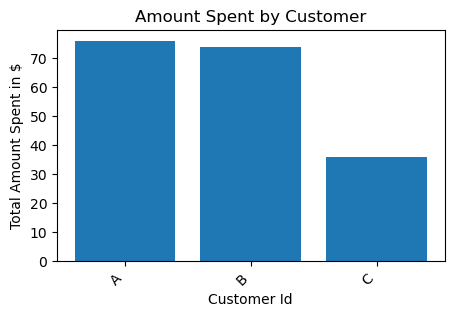

In [105]:
plt.figure(figsize=(5, 3))
plt.bar(sql_query_customer_amount_spent_results['customer_id'], sql_query_customer_amount_spent_results['total_amount_spent_dollars'])
plt.xlabel('Customer Id')
plt.ylabel('Total Amount Spent in $')
plt.title('Amount Spent by Customer')
plt.xticks(rotation=45, ha='right')
plt.show()

## How many days has each customer visited the restaurant?

In [106]:
sql_query_customer_spent_days = ''' 
SELECT 
  customer_id, 
  COUNT(
    DISTINCT (order_date)
  ) AS visit_days_count 
FROM 
  sales 
GROUP BY 
  customer_id 
ORDER by visit_days_count desc
'''

### SQL Query Explanation

Break down the query step by step:


1. **SELECT customer_id, COUNT(DISTINCT(order_date)) AS No_of_days**:
   - This line specifies the columns you want to retrieve in the result set.
   - `customer_id` is the unique identifier for customers.
   - `COUNT(DISTINCT(order_date))` calculates the count of distinct (unique) `order_date` values for each customer.
   - `AS visit_days_count` gives a name (alias) to the calculated count, which will be referred to as `visit_days_count` in the result set.

2. **FROM sales**:
   - This line specifies the table you are querying data from, which is the `sales` table.

3. **GROUP BY customer_id**:
   - This line groups the results by the `customer_id` column.
   - When you use `GROUP BY`, the query will group the data by unique values in the specified column, in this case, `customer_id`.

In summary, this SQL query retrieves data from the `sales` table, calculates the number of distinct days on which each customer made a purchase, and groups the results by `customer_id`. The final result will show a list of unique customer IDs along with the count of days they made a purchase, essentially indicating how many different days each customer has placed an order.


In [107]:
sql_query_customer_spent_days_results = pd.read_sql_query(sql_query_customer_spent_days, conn)

In [108]:
sql_query_customer_spent_days_results

,customer_id,visit_days_count
0,B,6
1,A,4
2,C,2


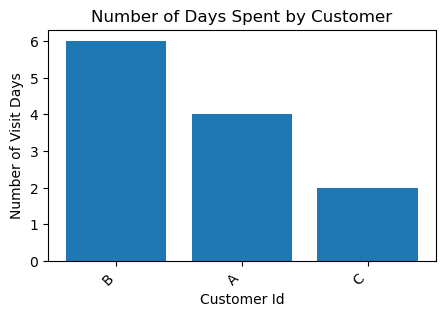

In [109]:
plt.figure(figsize=(5, 3))
plt.bar(sql_query_customer_spent_days_results['customer_id'], sql_query_customer_spent_days_results['visit_days_count'])
plt.xlabel('Customer Id')
plt.ylabel('Number of Visit Days')
plt.title('Number of Days Spent by Customer')
plt.xticks(rotation=45, ha='right')
plt.show()

## What was the first item from the menu purchased by each customer?

In [110]:
sql_query_first_customer_item = ''' select 
  distinct(customer_id), 
  product_name 
from 
  (
    select 
      customer_id, 
      product_name 
    from 
      (
        select 
          customer_id, 
          s.product_id, 
          product_name, 
          dense_rank() over(
            partition by customer_id 
            order by 
              order_date
          ) as r 
        from 
          sales as s 
          inner join menu as m on s.product_id = m.product_id
      ) c 
    where 
      r = 1
  ) k
 '''

### SQL Query Explanation

This SQL query is designed to retrieve specific data from the `sales` and `menu` tables, and it includes subqueries. Let's break it down step by step:

1. **SELECT DISTINCT(customer_id), product_name**:
   - This line specifies the columns you want to retrieve in the result set.
   - `customer_id` and `product_name` are the names of the columns you're selecting.
   - `DISTINCT` ensures that only unique combinations of `customer_id` and `product_name` are included in the result set.

2. **FROM (subquery)**:
   - This line indicates that you are selecting data from a subquery.
   - The subquery is enclosed in parentheses and is used to filter and organize the data before the final selection.

3. **(subquery)**:
   - This is the innermost subquery within the query.
   - It starts by joining the `sales` and `menu` tables on the `product_id` column.
   - It selects columns like `customer_id`, `product_name`, and calculates a ranking (`r`) for each row within a partition defined by `customer_id` based on the `order_date`.
   - This ranking is generated using the `DENSE_RANK()` window function, which assigns a rank to each record within the customer's orders, ordered by `order_date`.

4. **WHERE r = 1**:
   - This line filters the results from the inner subquery.
   - It selects only the rows where the `r` value (the rank) is equal to 1.
   - This effectively retrieves the first product ordered by each customer based on the `order_date`.

5. **SELECT DISTINCT(customer_id), product_name** (outermost query):
   - This is the outermost query that selects from the results of the inner subquery.
   - It retrieves the distinct combinations of `customer_id` and `product_name` for the products that each customer ordered first.

In summary, this SQL query retrieves the distinct combinations of `customer_id` and the name of the product they ordered first based on the `order_date`. It uses subqueries to filter and organize the data at different stages of the query.


In [111]:
sql_query_first_customer_item_results = pd.read_sql_query(sql_query_first_customer_item, conn)

In [112]:
sql_query_first_customer_item_results

,customer_id,product_name
0,A,sushi
1,A,curry
2,B,curry
3,C,ramen


## What is the most purchased item on the menu and how many times was it purchased by all customers?

In [113]:
sql_query_most_purchased_customer_item = ''' SELECT 
    product_name, COUNT(m.product_id) AS no_of_times_purchased
FROM
    sales AS s
        INNER JOIN
    menu AS m ON s.product_id = m.product_id
GROUP BY product_name
ORDER BY COUNT(m.product_id) DESC
'''

### SQL Query Explanation

This SQL query is designed to retrieve specific data from the `sales` and `menu` tables, calculate the number of times each product has been purchased, and order the results by the count of purchases in descending order. Let's break it down step by step:

1. **SELECT product_name, COUNT(m.product_id) AS no_of_times_purchased**:
   - This line specifies the columns you want to retrieve in the result set.
   - `product_name` is the name of the product.
   - `COUNT(m.product_id)` calculates the number of times each product has been purchased.
   - `AS no_of_times_purchased` gives a name (alias) to the calculated count, which will be referred to as `no_of_times_purchased` in the result set.

2. **FROM sales AS s INNER JOIN menu AS m ON s.product_id = m.product_id**:
   - This line specifies the tables you are querying data from.
   - `sales AS s` and `menu AS m` are table aliases, which are short names that make the query more readable.
   - `INNER JOIN` is used to combine rows from both tables based on a specified condition.
   - `ON s.product_id = m.product_id` is the join condition, indicating that rows from the `sales` table should be matched with rows from the `menu` table where the `product_id` values match. This links the two tables based on the common product identifier.

3. **GROUP BY product_name**:
   - This line groups the results by the `product_name` column.
   - When you use `GROUP BY`, the query will aggregate data for each unique value in the specified column.
   - In this case, it groups the data by product names, so the query will calculate the count of purchases for each unique product.

4. **ORDER BY COUNT(m.product_id) DESC**:
   - This line specifies the ordering of the results using the `ORDER BY` clause.
   - `COUNT(m.product_id)` is used as the sorting criteria, so the results will be ordered by the count of purchases in descending order.
   - This means that products with the highest number of purchases will appear at the top of the result set.

In summary, this SQL query retrieves data from the `sales` and `menu` tables, calculates the number of times each product has been purchased, groups the results by product name, and orders the results by the count of purchases in descending order. The final result will show a list of products along with the number of times each product has been purchased, with the most purchased products listed first.




In [114]:
sql_query_most_purchased_customer_item_results = pd.read_sql_query(sql_query_most_purchased_customer_item, conn)

In [115]:
sql_query_most_purchased_customer_item_results

,product_name,no_of_times_purchased
0,ramen,8
1,curry,4
2,sushi,3


#### Most Purchased Product is Ramen, you can also apply limit 1 at the end of the SQL query

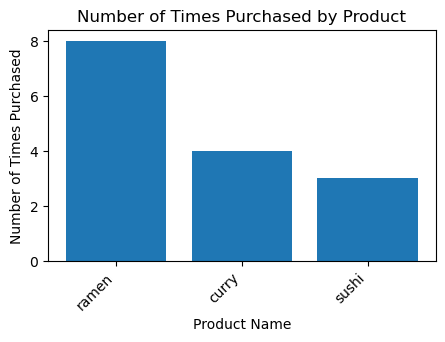

In [116]:
plt.figure(figsize=(5, 3))
plt.bar(sql_query_most_purchased_customer_item_results['product_name'], sql_query_most_purchased_customer_item_results['no_of_times_purchased'])
plt.xlabel('Product Name')
plt.ylabel('Number of Times Purchased')
plt.title('Number of Times Purchased by Product')
plt.xticks(rotation=45, ha='right')
plt.show()

## Which item was the most popular for each customer?

In [117]:
sql_query_most_popular_item_by_customer = ''' 
select 
  customer_id, 
  product_name, 
  No_of_times_purchased 
from 
  (
    select 
      customer_id, 
      product_name, 
      count(s.product_id) as No_of_times_purchased, 
      dense_rank() over(
        partition by customer_id 
        order by 
          count(s.product_id) desc
      ) as m 
    from 
      sales as s 
      inner join menu as m on s.product_id = m.product_id 
    group by 
      customer_id, 
      product_name
  ) k 
where 
  m = 1

''' 

### SQL Query Explanation

This SQL query is designed to retrieve specific data related to the most frequently purchased products by each customer. It uses subqueries and window functions to achieve this. Let's break it down step by step:

1. **SELECT customer_id, product_name, No_of_times_purchased**:
   - This line specifies the columns you want to retrieve in the result set.
   - `customer_id` is the unique identifier for customers.
   - `product_name` is the name of the product.
   - `No_of_times_purchased` is the count of times each product has been purchased.
   
2. **FROM (subquery)**:
   - This line indicates that you are selecting data from a subquery.
   - The subquery is enclosed in parentheses and is used to filter and organize the data before the final selection.

3. **(subquery)**:
   - This is the innermost subquery within the query.
   - It starts by joining the `sales` and `menu` tables on the `product_id` column.
   - It calculates the count of times each product has been purchased using `COUNT(s.product_id) as No_of_times_purchased`.
   - It also calculates a ranking (`m`) for each customer based on the count of product purchases.
   - The `DENSE_RANK()` window function assigns a rank to each customer within their partition (defined by `customer_id`) based on the count of product purchases. Customers who purchased the same number of products receive the same rank.

4. **WHERE m = 1**:
   - This line filters the results from the inner subquery.
   - It selects only the rows where the rank `m` is equal to 1.
   - This effectively retrieves the products that were purchased the most by each customer.

In summary, this SQL query retrieves data related to the most frequently purchased products by each customer. It uses subqueries and window functions to calculate the count of product purchases for each customer, assigns ranks based on purchase counts, and selects the products with the highest purchase count (rank 1) for each customer. The result set includes `customer_id`, `product_name`, and the count of times each product has been purchased.


In [118]:
sql_query_most_popular_item_by_customer_results = pd.read_sql_query(sql_query_most_popular_item_by_customer, conn)

In [119]:
sql_query_most_popular_item_by_customer_results

,customer_id,product_name,No_of_times_purchased
0,A,ramen,3
1,B,curry,2
2,B,sushi,2
3,B,ramen,2
4,C,ramen,3


## Which item was purchased first by the customer after they became a member?

In [120]:
sql_query_first_purchased_item_member = ''' 
SELECT 
  s.customer_id, 
  product_name
FROM 
  members AS m 
  INNER JOIN sales AS s ON m.customer_id = s.customer_id 
  INNER JOIN menu AS men ON s.product_id = men.product_id 
WHERE 
  order_date > join_date 
GROUP BY 
  product_name, 
  customer_id 
ORDER BY 
  customer_id

'''

### SQL Query Explanation


1. ** SELECT s.customer_id, product_name**:
   - This line specifies the columns you want to retrieve in the result set.
   - `s.customer_id` is the customer ID from the `sales` table.
   - `product_name` is the name of the product from the `menu` table.

2. **FROM members AS m INNER JOIN sales AS s ON m.customer_id = s.customer_id INNER JOIN menu AS men ON s.product_id = men.product_id**:
   - This line specifies the tables you are querying data from.
   - `members AS m` is given the alias `m`, representing the `members` table.
   - `sales AS s` is given the alias `s`, representing the `sales` table.
   - `menu AS men` is given the alias `men`, representing the `menu` table.
   - `INNER JOIN` is used to combine rows from different tables based on specified conditions.
   - The query joins `members` with `sales` based on matching `customer_id` and `sales` with `menu` based on matching `product_id`. This links the three tables together to access relevant data.

3. **WHERE order_date > join_date**:
   - This line filters the results using the `WHERE` clause.
   - It selects only the rows where the `order_date` (from the `sales` table) is greater than the `join_date` (from the `members` table).
   - This condition ensures that only purchases made after a member join date are included in the result set.

4. **GROUP BY product_name, customer_id**:
   - This line groups the results by two columns: `product_name` and `customer_id`.
   - When you use `GROUP BY`, the query aggregates data for each unique combination of the specified columns.
   - In this case, it groups the data by product name and customer ID, which allows you to see which products each customer has purchased.

5. **ORDER BY customer_id**:
   - This line specifies the ordering of the results using the `ORDER BY` clause.
   - It orders the results by the `customer_id` column in ascending order.
   - This means that the results will be sorted based on customer IDs.

In summary, this SQL query retrieves data about customers who made purchases after joining. It selects the customer ID (`s.customer_id`) and the name of the product (`product_name`) they purchased, but only for purchases made after their join date. The results are grouped by product name and customer ID, and they are ordered by customer ID in ascending order.


In [121]:
sql_query_first_purchased_item_member_results = pd.read_sql_query(sql_query_first_purchased_item_member, conn)

In [122]:
sql_query_first_purchased_item_member_results

,customer_id,product_name
0,A,ramen
1,B,sushi
2,B,ramen


## Which item was purchased just before the customer became a member?

In [123]:
sql_query_purchased_customer_member = '''
SELECT 
    s.customer_id, product_name
FROM
    members AS m
        INNER JOIN
    sales AS s ON m.customer_id = s.customer_id
        INNER JOIN
    menu AS men ON s.product_id = men.product_id
WHERE
    order_date < join_date
GROUP BY product_name , customer_id
ORDER BY customer_id
'''

In [124]:
sql_query_purchased_customer_member_results = pd.read_sql_query(sql_query_purchased_customer_member, conn)

In [125]:
sql_query_purchased_customer_member_results

,customer_id,product_name
0,A,sushi
1,A,curry
2,B,sushi
3,B,curry


## What is the total items and amount spent for each member before they became a member?

In [126]:
sql_query_total_amount_spent_per_member = '''
SELECT 
  s.customer_id, 
  COUNT(product_name) AS no_of_items, 
  SUM(price) AS amount_spent 
FROM 
  sales AS s 
  INNER JOIN menu AS m ON s.product_id = m.product_id 
  INNER JOIN members AS mb ON mb.customer_id = s.customer_id 
WHERE 
  join_date > order_date 
GROUP BY 
  customer_id 
ORDER BY 
  customer_id
'''

### SQL Query Explanation

This SQL query retrieves specific information from three tables (`sales`, `menu`, and `members`) to analyze customer purchases. Here's a step-by-step explanation:

1. **SELECT s.customer_id, COUNT(product_name) AS no_of_items, SUM(price) AS amount_spent**:
   - This line specifies the columns you want to retrieve in the result set.
   - `s.customer_id` represents the customer ID from the `sales` table.
   - `COUNT(product_name)` calculates the count of product names to determine the number of items purchased by each customer.
   - `SUM(price)` calculates the sum of prices to determine the total amount spent by each customer.
   - Both `COUNT` and `SUM` are used with aliases (`no_of_items` and `amount_spent`) to provide meaningful names in the result set.

2. **FROM sales AS s INNER JOIN menu AS m ON s.product_id = m.product_id INNER JOIN members AS mb ON mb.customer_id = s.customer_id**:
   - This line specifies the tables you are querying data from.
   - `sales AS s` is given the alias `s`, representing the `sales` table.
   - `menu AS m` is given the alias `m`, representing the `menu` table.
   - `members AS mb` is given the alias `mb`, representing the `members` table.
   - `INNER JOIN` is used to combine rows from different tables based on specified conditions.
   - The query joins `sales` with `menu` based on matching `product_id` and also joins `sales` with `members` based on matching `customer_id`, creating relationships between the three tables to access relevant data.

3. **WHERE join_date > order_date**:
   - This line filters the results using the `WHERE` clause.
   - It selects only the rows where the `join_date` (from the `members` table) is greater than the `order_date` (from the `sales` table).
   - This condition ensures that only purchases made after a customer joined are included in the result set.

4. **GROUP BY customer_id**:
   - This line groups the results by the `customer_id` column.
   - When you use `GROUP BY`, the query aggregates data for each unique value in the specified column.
   - In this case, it groups the data by customer ID, allowing you to calculate aggregate values for each customer.

5. **ORDER BY customer_id**:
   - This line specifies the ordering of the results using the `ORDER BY` clause.
   - It orders the results by the `customer_id` column in ascending order.
   - This means that the results will be sorted based on customer IDs.

In summary, this SQL query analyzes customer purchases by counting the number of items (`no_of_items`) purchased by each customer and calculating the total amount spent (`amount_spent`). It only considers purchases made after a customer joined, groups the results by customer ID, and orders the results by customer ID in ascending order.


In [127]:
sql_query_total_amount_spent_per_member_results = pd.read_sql_query(sql_query_total_amount_spent_per_member, conn)

In [128]:
sql_query_total_amount_spent_per_member_results

,customer_id,no_of_items,amount_spent
0,A,2,25.0
1,B,3,40.0


## If each $1 spent equates to 10 points and sushi has a 2x points multiplier - how many points would each customer have?


In [129]:
sql_query_customer_points = ''' 
SELECT 
    customer_id, product_name, SUM(points) AS total_points
FROM
    (SELECT 
        customer_id,
            product_name,
            CASE
                WHEN product_name = 'sushi' THEN 2 * (price) * 10
                ELSE 10 * (price)
            END AS points
    FROM
        menu AS m
    INNER JOIN sales AS s ON m.product_id = s.product_id) f
GROUP BY customer_id
'''

### SQL Query Explanation

This SQL query calculates the total points earned by each customer based on their purchases of specific products (e.g., 'sushi') from the `menu` and `sales` tables. Here's a step-by-step explanation:

1. **SELECT customer_id, product_name, SUM(points) AS total_points**:
   - This line specifies the columns you want to retrieve in the result set.
   - `customer_id` represents the unique identifier for customers.
   - `product_name` represents the name of the purchased product.
   - `SUM(points)` calculates the sum of the points earned for each customer's purchases.
   - The points calculation is based on the product's name and price.

2. **FROM (subquery) f**:
   - This line indicates that you are selecting data from a subquery and assigns it the alias `f`.
   - The subquery calculates the points earned for each customer's purchases of specific products and includes columns for `customer_id`, `product_name`, and `points`.

3. **(subquery)**:
   - This is the innermost subquery within the query.
   - It starts by joining the `menu` and `sales` tables on the `product_id` column to link product purchases with their respective prices.
   - It uses a `CASE` statement to calculate points based on the product name. For 'sushi' products, the points are calculated as `2 * (price) * 10`, while for other products, the points are calculated as `10 * (price)`.

4. **GROUP BY customer_id**:
   - This line groups the results by the `customer_id` column.
   - When you use `GROUP BY`, the query aggregates data for each unique value in the specified column.
   - In this case, it groups the data by customer ID, allowing you to calculate the total points earned by each customer.

In summary, this SQL query calculates the total points earned by each customer for their purchases, with the point calculation based on the product name and price. It uses a subquery to first calculate the points for each product purchase, and then it aggregates and groups the results by customer ID to calculate the total points for each customer.


In [130]:
sql_query_customer_points_results = pd.read_sql_query(sql_query_customer_points, conn)

In [131]:
sql_query_customer_points_results

,customer_id,product_name,total_points
0,A,sushi,860.0
1,B,curry,940.0
2,C,ramen,360.0


## In the first week after a customer joins the program (including their join date) they earn 2x points on all items, not just sushi - how many points do customer A and B have at the end of January?

In [132]:
sql_query_customer_points_jan_end = '''
WITH dates_cte AS (
    SELECT 
        m.customer_id, 
        m.join_date, 
        DATE_ADD(m.join_date, INTERVAL 6 DAY) AS valid_date, 
        DATE_SUB(DATE_ADD(LAST_DAY('2021-01-01'), INTERVAL 1 MONTH), INTERVAL 1 DAY) AS last_date
    FROM dannys_diner.members AS m
)

SELECT 
    s.customer_id, 
    SUM(
        CASE
            WHEN menu.product_name = 'sushi' THEN 2 * 10 * menu.price
            WHEN s.order_date BETWEEN dates.join_date AND dates.valid_date THEN 2 * 10 * menu.price
            ELSE 10 * menu.price
        END
    ) AS points
FROM dannys_diner.sales AS s
JOIN dates_cte AS dates
    ON s.customer_id = dates.customer_id
    AND s.order_date <= dates.last_date
JOIN dannys_diner.menu AS menu
    ON s.product_id = menu.product_id
GROUP BY s.customer_id;

'''

### SQL Query Explanation

This MySQL query calculates the total points earned by customers for their purchases of specific products, such as 'sushi,' within a specific date range. It uses a Common Table Expression (CTE) and joins multiple tables. Let's break it down step by step:

1. **WITH dates_cte AS (...)**:
   - This section defines a Common Table Expression (CTE) named `dates_cte`.
   - The CTE calculates relevant date values for each customer:
     - `join_date` is the date when the customer joined.
     - `valid_date` is the date six days after the `join_date`.
     - `last_date` is the last day of the month preceding '2021-01-01.'

2. **SELECT s.customer_id, SUM(...) AS points**:
   - This line specifies the columns you want to retrieve in the result set.
   - `s.customer_id` represents the customer ID from the `sales` table.
   - `SUM(...)` calculates the total points earned for each customer's purchases.
   - The points calculation is based on conditions that consider the product name, order date, and price.

3. **FROM dannys_diner.sales AS s**:
   - This line specifies the `sales` table with the alias `s`.

4. **JOIN dates_cte AS dates ON ...**:
   - This line joins the CTE `dates_cte` with the `sales` table based on certain conditions:
     - `s.customer_id = dates.customer_id` ensures that the customer IDs match.
     - `s.order_date <= dates.last_date` restricts the data to purchases made on or before the last date calculated in the CTE.

5. **JOIN dannys_diner.menu AS menu ON ...**:
   - This line joins the `menu` table with the alias `menu` based on the product ID (`s.product_id` matches `menu.product_id`).

6. **GROUP BY s.customer_id**:
   - This line groups the results by the `customer_id` column.
   - When you use `GROUP BY`, the query aggregates data for each unique value in the specified column.
   - In this case, it groups the data by customer ID, allowing you to calculate the total points earned by each customer.

In summary, this MySQL query calculates the total points earned by customers for their purchases. The points calculation is based on product names ('sushi'), order dates within specific date ranges (using the CTE), and product prices. The results are grouped by customer ID to provide the total points earned by each customer.


In [133]:
sql_query_customer_points_jan_end_results = pd.read_sql_query(sql_query_customer_points_jan_end, conn)

In [134]:
sql_query_customer_points_jan_end_results

,customer_id,points
0,B,940.0
1,A,1370.0
